In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.misc import find_files, GoogleSheet, ttprint
import geopandas as gpd
from pathlib import Path
from minio import Minio
import rasterio
import pyproj
from shapely.geometry import Point
import requests
import warnings
# from skgstat import Variogram
from shapely.geometry import Point
from eumap.mapper import SpaceOverlay

warnings.filterwarnings('default')

# os.environ['PROJ_LIB'] = '/opt/conda/share/proj'
folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data'
# /home/opengeohub/.local/bin

# Organize Germany data
- filter only DE data
- fix the issue of double points in the same spatial location
- overlay with predicted values

In [2]:
# # get data within Germany
# df = pd.read_parquet(f'{folder_path}/003_data_overlaid.organized.pq')
# nuts = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/NUTS_RG_20M_2021_3035.shp')
# nuts = nuts.loc[nuts['NUTS_ID']=='DE']

# # region = gpd.read_file(f'{folder_path}/nuts3_example_slope.gpkg')
# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
# df = df.to_crs(nuts.crs)

# df_filtered = gpd.sjoin(df, nuts, how='inner', predicate='intersects')
# # df_filtered = df_filtered.drop(columns=nuts.columns.difference(['geometry']), errors='ignore')

# df20 = df_filtered.loc[df_filtered['hzn_dep']<20]

# # depth aggregation
# from sklearn.linear_model import LinearRegression

# # Step 1: Identify locations with multiple depths
# locations_with_different_hzn_dep = df_filtered.groupby(['lat', 'lon']).filter(lambda x: x['hzn_dep'].nunique() > 1)

# # Step 2: Initialize a list to store results
# results = []

# # Step 3: Iterate over each unique location
# for (lat, lon), group in locations_with_different_hzn_dep.groupby(['lat', 'lon']):
#     # Fit a linear regression model between 'hzn_dep' and 'ocd'
#     X = group['hzn_dep'].values.reshape(-1, 1)
#     y = group['ocd'].values
#     model = LinearRegression().fit(X, y)
    
#     # Predict the 'ocd' value at a depth of 10 cm
#     ocd_at_10 = model.predict(np.array([[10]]))[0]
    
#     # Use the first row's data as a template, then update 'hzn_dep' and 'ocd'
#     template_row = group.iloc[0].copy()
#     template_row['hzn_dep'] = 10
#     template_row['ocd'] = ocd_at_10
    
#     # Store the result
#     results.append(template_row)

# new_df = pd.DataFrame(results)
# new_df['depth'] = 'multiple'
# dfvv = df_filtered.drop(index=locations_with_different_hzn_dep.index)
# dfvv['depth'] = 'single'
# df20['depth'] = 'upper 20'
# dfvv = pd.concat([dfvv, new_df, df20], ignore_index=True)

# dfvv = dfvv.drop(columns=['geometry', 'index_right', 'NUTS_ID', 'LEVL_CODE',
#        'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE',
#        'COAST_TYPE', 'FID'])

# # save files
# dfvv.to_csv(f'{folder_path}/data_de.depth.organized.csv', index=False)


# Overlay with predicted SOCD maps

In [3]:
# df = pd.read_csv(f'{folder_path}/data_de.depth.organized.csv', low_memory=False)
# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
# df = df.to_crs("EPSG:3035")

# mm = []
# for year in df['time'].unique():
#     start = int((year//4)*4)
#     end = int((year//4 + 1)*4)
#     # if start != 2004:
#     #     continue
    
    # fn = [f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
    #       f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
    #       f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif']
#     fp = [Path(iiii) for iiii in fn]
    
#     temp = df.loc[df['time']==year]
    
#     temp = SpaceOverlay(
#         points=temp, 
#         fn_layers=fp, verbose=True
#     ).run()
    
#     fname = ['ocd_map','ocd_p025','ocd_p975']
#     fn = [ii.split('/')[-1][0:-4] for ii in fn]
#     name_map = dict(zip(fn,fname))
#     temp = temp.rename(columns = name_map)
    
#     temp = temp.drop(columns=['overlay_id', 'geometry'])
#     mm.append(temp)
    
# dfm = pd.concat(mm)
# dfm.to_csv(f'{folder_path}/data_de.depth.organized.csv',index=False)

In [4]:
# # pixel level std, assume normality
# dfm['std'] = (dfm['ocd_p975']-dfm['ocd_p025'])/40
# # standardize residual with std
# dfm['ocd_map'] = dfm['ocd_map']/10
# dfm['residual'] = dfm['ocd_map']-dfm['ocd']
# dfm['std_rsd'] = dfm['residual']/dfm['std']
# dfm = dfm.dropna(subset=['residual'])
# dfm.to_csv(f'{folder_path}/data_de.depth.organized.csv',index=False)

# # check why nan exists
# # turns out they are from city area
# dfnan = dfv.loc[dfv[['ocd_map','ocd_p025','ocd_p975']].isnull().any(axis=1)]
# dfnan.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/nan_check.csv',index=False)

# Calculate variogram
- calculate the distance, and differences between all data pairs
- get variogram, and reverse it to get 
- fix the issue of double points in the same spatial location
- overlay with predicted values

In [5]:
# calculate the distances between data pairs
df = pd.read_csv(f'{folder_path}/data_de.depth.organized.csv', low_memory=False)
dfv = df.loc[df['depth'] != 'upper 20']

In [6]:
import numpy as np

gdf = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")
gdft = gdf#.iloc[0:500]
gdf_utm32n = gdft.to_crs(epsg=32632)
gdf_utm32n = gdf_utm32n.reset_index(drop=True)

all_dists = []
all_diffs = []
ms = []
for index, row in gdf_utm32n.iterrows():
    iii = index + 1
    reference_point = gdf_utm32n.iloc[index].geometry
    dists = gdf_utm32n.iloc[iii:].geometry.distance(reference_point).values / 1000
    reference_values = gdf_utm32n.iloc[index]['std_rsd']
    diffs = (gdf_utm32n.iloc[iii:]['std_rsd'] - reference_values) ** 2 / 2
    ms.append(len(diffs))
    # print(ms)
    
    all_dists.extend(dists)
    all_diffs.extend(diffs)

all_dists = np.array(all_dists)
all_diffs = np.array(all_diffs)

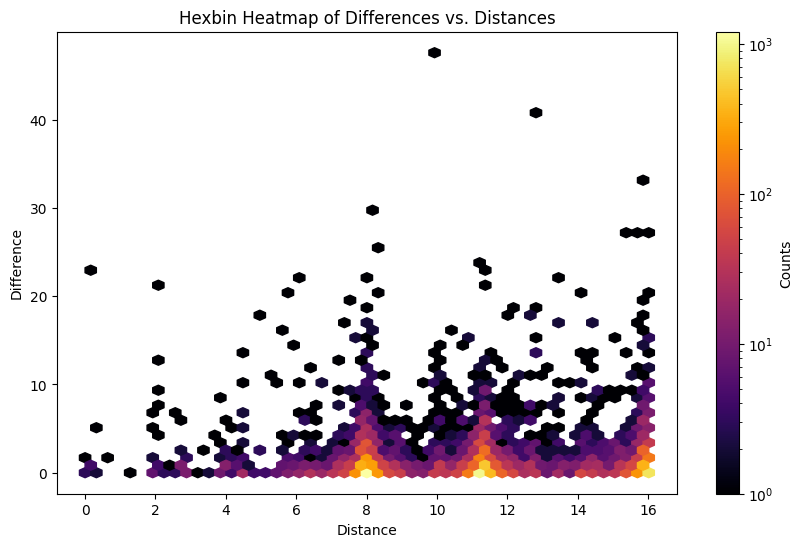

In [7]:
import matplotlib.pyplot as plt

# Ensure the data is sorted
all_dists_sorted = np.array(all_dists)[np.argsort(all_dists)]
all_diffs_sorted = np.array(all_diffs)[np.argsort(all_dists)]

# Create a hexbin plot
plt.figure(figsize=(10, 6))
hb = plt.hexbin(all_dists_sorted[0:10000], all_diffs_sorted[0:10000], gridsize=50, bins='log',cmap='inferno', mincnt=1)
# plt.xlim([0,20])
# Add color bar to indicate the counts in the hexagons
cb = plt.colorbar(hb, label='Counts')

# Labels and title
plt.xlabel('Distance')
plt.ylabel('Difference')
plt.title('Hexbin Heatmap of Differences vs. Distances')

# Show plot
plt.show()


In [8]:
from scipy.optimize import curve_fit
# Define variogram models
def spherical_model(h, nugget, sill, range_):
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(- (h**2) / (range_**2)))

# Use curve_fit to fit the empirical variogram data to a model
def fit_variogram_model(model, h, gamma):
    # Initial guess for parameters: nugget, sill, range
    initial_params = [0.1, 1.0, 10.0]
    
    # Fit the model to the data
    params, _ = curve_fit(model, h, gamma, p0=initial_params)
    
    return params

def correlation_function(h, nugget, sill, range_):
    # Calculate the variogram value at distance h
    gamma_h = exponential_model(h, nugget, sill, range_)
    # Calculate and return the correlation function value
    return (sill - gamma_h) / sill

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Sill estimated by exponential variogram model:  1.3745963625991293


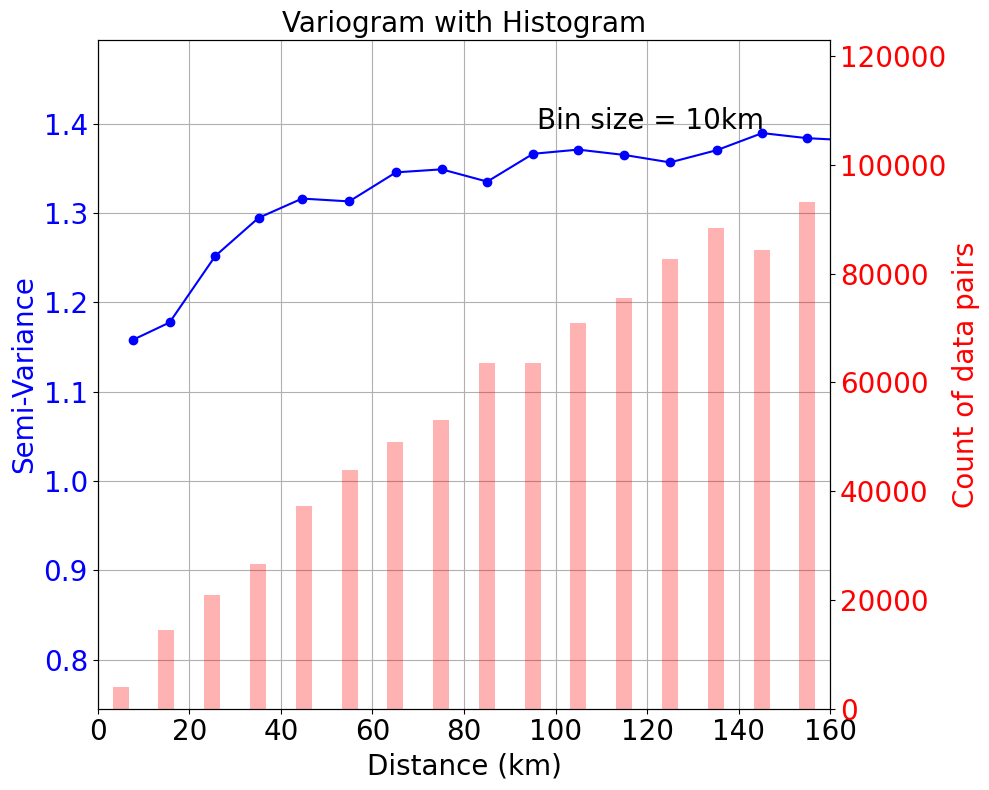

In [9]:
bins_size = 10
bin_edges = np.arange(0, max(all_dists), bins_size)  # Bins from 0 km to the max distance, in 1 km increments
bin_indices = np.digitize(all_dists, bin_edges)

# binned_distances = np.zeros(len(bin_edges) - 1)
binned_variograms = np.zeros(len(bin_edges) - 1)
binned_dist = np.zeros(len(bin_edges) - 1)
binned_number = np.zeros(len(bin_edges) - 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoint of each bin

for i in range(1, len(bin_edges)):
    # Select data in the current bin
    mask = bin_indices == i
    binned_number[i - 1] = np.sum(mask)
    if np.sum(mask) > 0:
        binned_dist[i - 1] = np.nanmean(all_dists[mask])  # Average semi-variance for this bin
        binned_variograms[i - 1] = np.nanmean(all_diffs[mask])  # Average semi-variance for this bin

# Removing bins with zero count
mask_nonzero = binned_number > 0

# Filter the data
filtered_binned_variograms = binned_variograms[mask_nonzero]
filtered_binned_dist = binned_dist[mask_nonzero]
filtered_binned_number = binned_number[mask_nonzero]
filtered_bin_centers = bin_centers[mask_nonzero]

# Filter the empirical data to only include distances <= 150 km
mask_150 = filtered_binned_dist <= 150
filtered_distances = filtered_binned_dist[mask_150]
filtered_variograms = filtered_binned_variograms[mask_150]

# y = correlation_function(distance, *params_exponential)
params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)

print('Sill estimated by exponential variogram model: ', params_exponential[1])

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(filtered_binned_dist, filtered_binned_variograms, marker='o', linestyle='-', color='b', label='Variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
# ax1.set_xlim([0, 200])
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(filtered_bin_centers, filtered_binned_number, width=3.5, alpha=0.3, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

plt.title('Variogram with Histogram', fontsize=20)
ax1.grid(True)
ax1.set_xlim([0,160])
# ax1.set_ylim([0,1])
fig.tight_layout()  

plt.show()

# Theoretical variogram and correlation functions, with inflation factor considered

In [10]:
# dfv = dfv.loc[dfv['std_rsd']>-3]
factor = np.sqrt(params_exponential[1]) #inflation factor
dfv['std_rsd_corrected'] = dfv['std_rsd']/factor

import numpy as np
gdf = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")
gdft = gdf#.iloc[0:500]
gdf_utm32n = gdft.to_crs(epsg=32632)
gdf_utm32n = gdf_utm32n.reset_index(drop=True)

all_dists = []
all_diffs = []
ms = []
for index, row in gdf_utm32n.iterrows():
    iii = index + 1
    reference_point = gdf_utm32n.iloc[index].geometry
    dists = gdf_utm32n.iloc[iii:].geometry.distance(reference_point).values / 1000
    reference_values = gdf_utm32n.iloc[index]['std_rsd_corrected']
    diffs = (gdf_utm32n.iloc[iii:]['std_rsd_corrected'] - reference_values) ** 2 / 2
    ms.append(len(diffs))
    # print(ms)
    
    all_dists.extend(dists)
    all_diffs.extend(diffs)

all_dists = np.array(all_dists)
all_diffs = np.array(all_diffs)

bins_size = 10
bin_edges = np.arange(0, max(all_dists), bins_size)  # Bins from 0 km to the max distance, in 1 km increments
bin_indices = np.digitize(all_dists, bin_edges)

# binned_distances = np.zeros(len(bin_edges) - 1)
binned_variograms = np.zeros(len(bin_edges) - 1)
binned_dist = np.zeros(len(bin_edges) - 1)
binned_number = np.zeros(len(bin_edges) - 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoint of each bin

for i in range(1, len(bin_edges)):
    # Select data in the current bin
    mask = bin_indices == i
    binned_number[i - 1] = np.sum(mask)
    if np.sum(mask) > 0:
        binned_dist[i - 1] = np.nanmean(all_dists[mask])  # Average semi-variance for this bin
        binned_variograms[i - 1] = np.nanmean(all_diffs[mask])  # Average semi-variance for this bin

# Removing bins with zero count
mask_nonzero = binned_number > 0

# Filter the data
filtered_binned_variograms = binned_variograms[mask_nonzero]
filtered_binned_dist = binned_dist[mask_nonzero]
filtered_binned_number = binned_number[mask_nonzero]
filtered_bin_centers = bin_centers[mask_nonzero]

# theoretical variogram
# Filter the empirical data to only include distances <= 150 km
mask_150 = filtered_binned_dist <= 150
filtered_distances = filtered_binned_dist[mask_150]
filtered_variograms = filtered_binned_variograms[mask_150]

# y = correlation_function(distance, *params_exponential)
params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)

# Generate the fitted variogram lines within the range [0, 150] km
h_vals = np.linspace(0, 150, 300)
fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)

/tmp/ipykernel_11563/673839503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv['std_rsd_corrected'] = dfv['std_rsd']/factor
/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


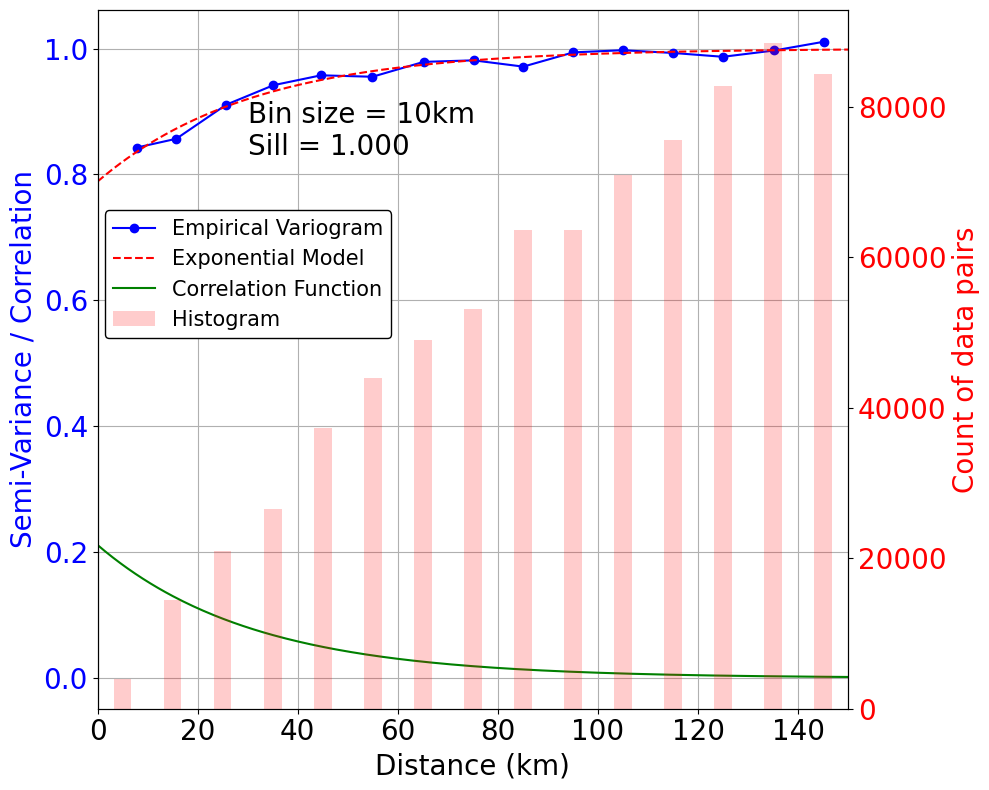

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the correlation function values using the exponential model
correlation_values = correlation_function(h_vals, *params_exponential)

fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot empirical variogram for the range [0, 150]
ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')

# Plot the exponential model
ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')

# # Plot fitted spherical and Gaussian models (optional, if you want to compare)
# ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
# ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='orange', label='Gaussian Model')

# Plot the correlation function on the same axis as the semi-variance
ax1.plot(h_vals, correlation_values, linestyle='-', color='green', label='Correlation Function')

# Set labels and titles
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance / Correlation', color='b', fontsize=20)  # Shared y-axis label
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.2, 0.87, f'Bin size = {bins_size}km\nSill = {params_exponential[1]:.3f}', 
         ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position
ax1.grid(True)
ax1.set_xlim([0, 150])

# Plot the histogram on the secondary y-axis
ax2 = ax1.twinx()
ax2.bar(filtered_bin_centers[mask_150], filtered_binned_number[mask_150], width=3.5, alpha=0.2, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=(0.01,0.53), fontsize=15, facecolor='white', edgecolor='black', framealpha=1)

# Final layout adjustments
fig.tight_layout()
# plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/plot_variogram_corrected.pdf", format='pdf',dpi=300)

# Show the plot
plt.show()


In [12]:
params_exponential

array([ 0.78881424,  1.        , 30.99414487])